# Computational Phase Retrieval with Tensor Methods

## Device Information

In [1]:
!nvidia-smi

Wed Aug 18 15:45:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P0    14W /  N/A |    605MiB /  3911MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Required Libraries

In [2]:
import functools
from scipy.optimize import minimize
from numba import jit, njit, prange
import warnings
from matplotlib import rc, rcParams
import seaborn as sns
import matplotlib.cm as cm
from PIL import Image
import os
import time
import cv2
import tensorly as tl
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")


gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        print("Num GPUs Available: ", len(gpus))
        for gpu in gpus:
            # Allow memory growth for the GPU.
            # Reference: https://www.tensorflow.org/guide/gpu
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized.
        print(e)

plt.style.use('dark_background')
tl.set_backend('tensorflow')

rc('text', usetex=False)



Tensorflow version: 2.5.0
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## GPU Benchmark

Run preliminarily to avoid cold-start.

Reference: https://www.tensorflow.org/guide/gpu

In [8]:
tf.debugging.set_log_device_placement(True)

n = 1000
num_iters = 10

'''
Test with TensorFlow GPU.
'''
start_tf = time.time()

for i in range(num_iters):
    # Tensors are defaultly placed on the GPU (CPU would be considerably 
    # slower due to the incurred communication cost).
    a = tf.ones((n, n))
    b = tf.ones((n, n))

    # Run on the GPU
    c = tf.matmul(a, b)

print(f'Elapsed time with TensorFlow GPU: {time.time() - start_tf}')

'''
Test with Numpy.
'''
start_np = time.time()

for i in range(num_iters):
    a = np.ones((n, n))
    b = np.ones((n, n))

    c = np.dot(a, b)

print(f'Elapsed time with Numpy: {time.time() - start_np}') # CAN BE SLOW


Elapsed time with TensorFlow GPU: 0.010373353958129883
Elapsed time with Numpy: 0.3589625358581543


## Low Rank Phase Retrieval

References:

\[1\] Namrata Vaswani, Seyedehsara Nayer, Yonina C. Eldar. *Low Rank Phase Retrieval*. https://rutgers.box.com/s/dntl0sh157p62rgi1zerdaxrqthugr32

\[2\] Namrata Vaswani. *Nonconvex Structured Phase Retrieval*. https://rutgers.box.com/s/x02w8frd1ep01cxdjlnojufa9npvstsz.

\[3\] Tamara G. Kolda, Brett W. Bader. *Tensor Decompositions and Applications*. https://rutgers.box.com/s/aq9psx3mgwhms6rrzlhn94h56c3oshox. 




### Define Data Directories

In [4]:
INPUT_DIR = './videos/' # directory of the test videos
OUTPUT_DIR = './output/' # output directory
FRAMES_DIR = './ouput/frames/' # output directory of the extracted video frames 

### Load the Test Video

In [12]:
# Read the video.
video_path = INPUT_DIR + os.listdir(INPUT_DIR)[1] # define video path
cap = cv2.VideoCapture(video_path) # read the video from path
video_name = os.listdir(INPUT_DIR)[1].split('.')[0] # get the name of the video
print(video_name)

# Creat the folder to store the extracted frames of the video.
try:
    if not os.path.exists(FRAMES_DIR + video_name):
        os.makedirs(FRAMES_DIR + video_name)
    else:
        print('Directory already exists!')
except OSError:
    print('OS ERROR')

k = 0 # frame number, k = 0, 1, 2, ..., Q - 1
extracted_frames = []
Rhat = 0
while (True):
    # Capture the video frame-by-frame.
    # Code adopted: https://docs.opencv.org/3.4/dd/d43
    # tutorial_py_video_display.html
    ret, frame = cap.read()

    # If the frame is read correctly the return boolean (ret) is true.
    if not ret:
        print("Cannot receive frame (probably end of stream). Exiting...")
        break
    elif k < 5:
        # Convert the frame to grayscale.
        gray_frame_original = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        scale = 0.125
        width = int(gray_frame_original.shape[1] * scale)
        height = int(gray_frame_original.shape[0] * scale)
        gray_frame = cv2.resize(gray_frame_original, (width, height))
        name = FRAMES_DIR + video_name + '/frame-' + str(k) + '.jpg'
        print('DEBUG: Captured...' + name)
        svds = np.linalg.svd(gray_frame)[1]
        max_svd, min_svd = np.max(svds), np.min(svds)
        normalized_svds = svds / (max_svd - min_svd)
        Rhat += np.sum(normalized_svds > 0.1)
        cv2.imwrite(name, gray_frame)

        # plt.plot(range(480), normalized_svds)
        # plt.show()
        
        extracted_frames.append(gray_frame)

        k += 1

Rhat = Rhat // k + 1
print('Approximate rank of each frame: ', Rhat)

# Release the capture when finished.
cap.release()
cv2.destroyAllWindows()

Mouse
Directory already exists!
DEBUG: Captured..../ouput/frames/Mouse/frame-0.jpg
DEBUG: Captured..../ouput/frames/Mouse/frame-1.jpg
DEBUG: Captured..../ouput/frames/Mouse/frame-2.jpg
DEBUG: Captured..../ouput/frames/Mouse/frame-3.jpg
DEBUG: Captured..../ouput/frames/Mouse/frame-4.jpg
Cannot receive frame (probably end of stream). Exiting...
Approximate rank of each frame:  4


### Create the true signal tensor.

Tensors are multi-dimensional arrays with a uniform type (`dtype`). All tensors are immutable like Python numbers and strings: you can never update the contents of a tensor, only create a new one.

**Note**: In libraries like tensorflow, the rank of the tensor actually denotes the order of the tensor in our convention. We call the `rank` of a tensor in a similar manner as the rank of a matrix.

The gray-scaled signal is modeled as a three-ordered tensor $\boldsymbol{\mathcal{X}} \in \mathbb{R}^{I_1 \times I_2 \times q}$, where $I_1 \times I_2$ correspond to the pixel coordinates within each frame and $q$ is the total number of frames captured.

**Signal Dimension**

In [13]:
Xast = tf.convert_to_tensor(extracted_frames, tf.float32)
Q, I1, I2 = Xast.shape
Xast = tf.reshape(Xast, [I1, I2, Q])
print(f'The dimension of the true signal tensor: I1 x I2 x Q: {I1} x {I2} x {Q}')
print(f'Sample complexity for rank {Rhat}: O({(Q + I1 + I2) * Rhat})')

The dimension of the true signal tensor: I1 x I2 x Q: 54 x 95 x 5
Sample complexity for rank 4: O(616)


### Generate Phaseless Measurements

In [14]:
def initialize_zeros(dim):
    """Helper function to initiaize a tf.Variable with zero entries given a
    specific dim.

    Args:
        dim (list): a list describing the target dimension.

    Returns:
        tf.Variable(shape=dim, tf.float32): initialized tf.Variable
    """
    
    initializer = tf.zeros_initializer()
    return tf.Variable(initializer(shape=dim, dtype=tf.float32))

#### Generate the measurement tensor

In [18]:
def generate_measurement_tensor(M, I1, I2, Q):
    """Generate a measurement tensor A (M x I1 x I2 x Q) using i.i.d. random
    Gaussian sample matrices (I1 x I2) along each M, Q dimension.

    Args:
        M (int): number of measurements for each frame
        I1 (int): I1 dimension of the frame
        I2 (int): I2 dimension of the frame
        Q (int): number of frames

    Returns:
        [tf.Variable, dtype=tf.float32]: [the measurement tensor of dimension
        M x I1 x I2 x Q].
    """
    A = initialize_zeros([M, I1, I2, Q]) # measurement tensor

    # Generate i.i.d. measurement tensors.
    for j in range(M):
        for k in range(Q):
            # i.i.d. normal measurements from the independent number stream
            A[j, :, :, k].assign(tf.random.normal([I1, I2]))
    
    return A

start = time.time()
M = 2000
A = generate_measurement_tensor(M, I1, I2, Q)
print(f'Elapsed time: {time.time() - start} seconds.')

Elapsed time: 3.815293073654175 seconds.


#### Generate measurements.

In [19]:
Y = tf.Variable(tf.zeros([M, Q]))
norms_Xast = np.zeros(Q)

for k in range(Q):
    # Normalize the true signal tensor with Frobenius norm.
    normalized_Xast, norms_Xast[k] = tf.linalg.normalize(
        Xast[:, :, k], ord='fro', axis=[0, 1])
    Y[:, k].assign(
        tf.tensordot(A[:, :, :, k], normalized_Xast, axes=([1, 2], [0, 1])))

In [20]:
def initialize(I1, I2, Q, R):
    """Initialize factor matrices. Currently only work for three-way
    decomposition, i.e., we assume the true signal tensor Xast can be factorized
    into three factor matrices: Xast = [U1, U2, B].

    Considering the potential extension to higher dimensional factorization and
    the special factor matrix preserved for the dimension corresponding to the
    number of frames of the signal, the initialization function returns a list
    containing the factor matrices excluding the factor matrix B, which is
    called U = [U1, U2, ...], alongwith the factor matrix B.

    Args:
        I1 (int): I1 dimension of the signal frame.
        I2 (int): I2 dimension of the signal frame.
        Q (int): number of frames.
        R (int): rank dimension of the factor matrices.

    Returns:
        tuple: a tuple containing a list of factor matrices U's and the factor
        matrix B.
    """

    U1 = tf.Variable(tf.random.normal([I1, R]))
    U2 = tf.Variable(tf.random.normal([I2, R]))
    B = tf.Variable(tf.random.normal([Q, R]))
    
    return [U1, U2], B

In [21]:
def kruskal(U, B, R, Lambda=None, type='CP'):
    """Construct Tensor from Kruskal Formulation.

        Args:
            U: list consisting of two factor matrices U1 (I1 x R)
                and U2 (I2 x R) for the three-way case.
            B: the B (Q x R) factor matrix.
            R: assumped rank (a scalar) of the low-rank tensor.
            Lambda: normalization factors (length R).
        
        Returns:
            Xhat: signal estimate (I1 x I2 x q).
    """
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if type == 'CP':
        U1, U2 = U[0], U[1]
        I1, I2, Q = U1.shape[0], U2.shape[0], B.shape[0]
        Xhat = tf.zeros([I1, I2, q])
        if Lambda is None:
            Lambda = tf.ones([R,])
        for r in range(R):
            U1U2 = tf.tensordot(U1[:, r], U2[:, r], axes=0)
            Xhat += Lambda[r] * tf.tensordot(U1U2, B[:, r], axes=0)
        return Xhat

    return None

In [36]:
def descent(Uhat, Bhat, A, Y, R, max_iter):
    """Descent step of the ALS algorithm, currently only works for three-way
    decomposition.

    Args:
        Uhat (list):  a list containing factor matrices with after the initial
        estimates, i.e., [U1, U2, ...]
        Bhat (tf.Variable(dim=[Q, R], dtype=tf.float32)): initial estimate for
        the factor matrix B.
        A (tf.Variable(dim=[M, I1, I2, Q], dtype=tf.float32)): the measurement
        tensor.
        Y (tf.Tensor(dim=[M, Q], dtype=tf.float32)): the phaseless measurements,
        currently only linear projections.
        R (int): estimated rank
        max_iter (int): maximum number of iterations.

    Returns:
        tuple: a tuple containing U (a list of factor matrices excluding factor
        matrix B which accounts for the total number of frames) and the factor 
        matrix B.
    """
    U1, U2 = Uhat[0], Uhat[1]
    I1, I2 = U1.shape[0], U2.shape[0]
    m = A.shape[0]
    q = Bhat.shape[0]

    '''
    Define optimizer functions.
    '''
    @tf.function
    def solve_U1():
        """Helper function to solve the least squares 
            problem for factor matrix U1.
        """
        loss = 0
        m, I1, I2, q = A.shape
        R = Bhat.shape[1]
        vec_U1 = tf.reshape(U1, [I1 * R,])

        for k in range(q):
            yk = Y[:,k] # for linear projections
            Ak = A[:,:,:,k]
            bk = tf.reshape(Bhat[k,:], [1, R])

            # dim bk khatri_rao U2: R x I2
            U2B_kr = tf.transpose(tl.tenalg.khatri_rao([bk, U2]))
            A_kr = tl.tenalg.mode_dot(Ak, U2B_kr, 2)
            mat_A_kr = tf.reshape(A_kr, [m, I1 * R])
            
            yhat = tf.linalg.matvec(mat_A_kr, vec_U1)

            loss += (1 / m) * tf.math.reduce_sum(tf.square(yhat - yk))

        return loss
    
    @tf.function
    def solve_U2():
        """Helper function to solve the least squares 
            problem for factor matrix U2.
        """
        loss = 0
        m, I1, I2, q = A.shape
        R = Bhat.shape[1]

        vec_U2 = tf.reshape(U2, [I2 * R,])

        for k in range(q):
            yk = Y[:,k] # for linear projections
            Ak = tf.reshape(A[:,:,:,k], [m, I2, I1])
            bk = tf.reshape(Bhat[k,:], [1, R])

            # dim bk khatri_rao U1: R x I1
            U1B_kr = tf.transpose(tl.tenalg.khatri_rao([bk, U1]))
            A_kr = tl.tenalg.mode_dot(Ak, U1B_kr, 2)
            mat_A_kr = tf.reshape(A_kr, [m, I2 * R])

            yhat = tf.linalg.matvec(mat_A_kr, vec_U2)
            
            loss += (1 / m) * tf.math.reduce_sum(tf.square(yhat - yk))

        return loss
    
    def solve_B():
        least_squares_bks = []

        for i in range(q):
            @tf.function
            def solve_bk():
                m, I1, I2 = A.shape[0], A.shape[1], A.shape[2]
                bk = Bhat[k, :]
                vec_bk = tf.reshape(bk, [R,])

                U2U1_kr = tl.tenalg.khatri_rao([U2, U1])
                mat_Ak = tf.reshape(Ak, (m, I1 * I2))
                A_kr = tf.linalg.matmul(mat_Ak, U2U1_kr)
                mat_A_kr = tf.reshape(A_kr, (m, R))
                yhat = tf.linalg.matvec(mat_A_kr, vec_bk)

                return (1 / m) * tf.math.reduce_sum(tf.square(yhat - yk))
                
            least_squares_bks.append(solve_bk)
        
        return least_squares_bks
    
    '''
    Perform optimizations.
    '''

    opt = tf.keras.optimizers.SGD()
    opt_iters = 100

    least_squares_bks = solve_B()

    for t in range(max_iter):
        print(f'Iteration-{t}')
        print('Computing....')
        # Cy = np.zeros([m, q]).astype('float32')

        '''
        Update Phase (for complex measurements only).
        '''
        # for k in range(q):
        #     AX = tf.tensordot(
        #         A[:,:,:,k], Xhat[:,:,k], axes=([1, 2], [0, 1]))
        #     Ck = tf.linalg.diag(tf.math.angle(AX))
        #     Cy[:, k] = tf.linalg.matvec(Ck, Y[:,k])
        
        '''
        Solve for U1.
        '''
        for _ in range(opt_iters):
            opt.minimize(solve_U1, var_list=[U1])
        
        print('U1 optimized')

        '''
        Solve for U2.
        '''
        for _ in range(opt_iters):
            opt.minimize(solve_U2, var_list=[U2])
        
        print('U2 optimized')

        '''
        Solve for bk's.
        '''
        for k in range(q):
            yk = Y[:,k]
            Ak = A[:, :, :, k]

            for _ in range(opt_iters):
                opt.minimize(least_squares_bks[k], var_list=[Bhat])
        
        print('Bhat optimized')
    
    Uhat = [U1, U2]
    
    return Uhat, Bhat


In [37]:
def plrpr(A, Y, R=5, max_iter=1):
    """Polyadic Low Rank Phase Retrieval.
    """
    Uinit, Binit = initialize(I1, I2, q, R)
    
    Uhat, Bhat = descent(Uinit, Binit, A, Y, R, max_iter)
    
    Xhat = kruskal(Uhat, Bhat, R)
    
    return Xhat

Iteration-0
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-1
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-2
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-3
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-4
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-5
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-6
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-7
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-8
Computing....
U1 optimized
U2 optimized
Bhat optimized
Iteration-9
Computing....
U1 optimized
U2 optimized


findfont: Font family ['Cubano'] not found. Falling back to DejaVu Sans.


Bhat optimized


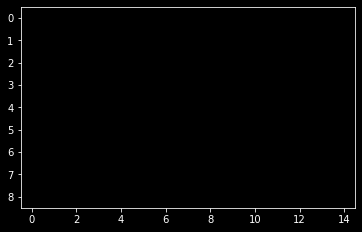

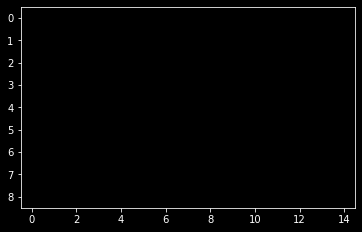

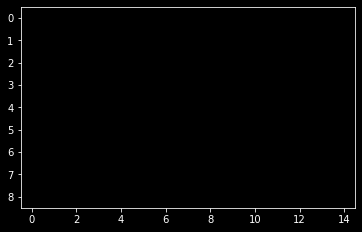

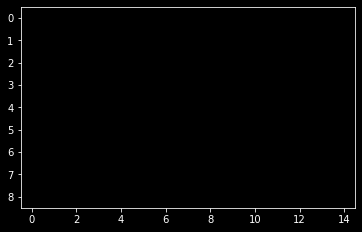

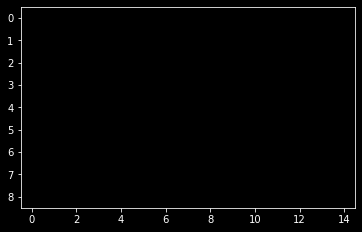

InvalidArgumentError: Input to reshape is a tensor with 0 values, but the requested shape has 675 [Op:Reshape]

In [39]:
def test_plrpr(A, Y, norms_Xast, R=10, max_iter=10):
    Xhat = plrpr(A, Y, R, max_iter)
    reconstructed_frames = []
    for k in range(Q):
        plt.imshow(Xhat[:,:,k])
        plt.show()
        # X = tf.multiply(norms_Xast[k], Xhat[:,:,k])
        # maxdiff = tf.math.reduce_max(X) - tf.math.reduce_min(X)
        
        # frame = tf.multiply(tf.cast((X - tf.math.reduce_min(X)) / maxdiff, tf.int8), 255)
        # filename = FRAMES_DIR + video_name + f'/frame-reconstructed-{k}' + '.jpg'
        # cv2.imwrite(filename, frame.numpy().astype(int))
        # reconstructed_frames.append(frame.numpy().astype(int))

    return tf.convert_to_tensor(reconstructed_frames, dtype=tf.int8)

Xhat = tf.reshape(test_plrpr(A, Y, norms_Xast, R = 20, max_iter = 10), [I1, I2, q])

print(f'Reconstructed error: {tf.math.reduce_sum(tf.math.abs(Xhat - tf.cast(Xast, tf.int8)))}')

In [32]:
tf.print(norm_Xast)

array([1267.95935059, 1236.1451416 , 1379.36218262, 1370.62683105,
       1196.58178711, 1274.48925781, 1235.36914062, 1379.56262207,
       1372.66015625, 1197.1607666 ])


In [38]:
tf.print(Xast)

[[[60 71 94 ... 235 245 146]
  [139 76 108 ... 94 114 44]
  [16 32 41 ... 121 96 55]
  ...
  [57 63 71 ... 179 190 199]
  [193 161 102 ... 94 110 52]
  [43 105 235 ... 108 89 0]]

 [[59 68 94 ... 47 57 40]
  [34 29 123 ... 93 120 0]
  [0 0 0 ... 26 45 49]
  ...
  [60 71 94 ... 235 245 150]
  [139 76 108 ... 94 114 44]
  [14 37 48 ... 123 96 55]]

 [[55 64 93 ... 0 0 0]
  [0 0 26 ... 93 121 0]
  [0 0 0 ... 29 46 47]
  ...
  [59 68 94 ... 48 54 40]
  [34 30 123 ... 93 120 0]
  [0 0 0 ... 26 45 49]]

 ...

 [[57 65 78 ... 215 227 232]
  [223 179 117 ... 78 84 96]
  [118 170 204 ... 113 65 39]
  ...
  [37 52 77 ... 238 242 248]
  [244 187 127 ... 78 87 95]
  [136 162 215 ... 116 70 44]]

 [[60 68 78 ... 204 218 225]
  [220 174 111 ... 71 78 83]
  [101 148 180 ... 99 57 31]
  ...
  [58 65 78 ... 215 227 232]
  [222 178 115 ... 78 84 98]
  [119 171 205 ... 110 64 38]]

 [[56 61 71 ... 180 192 199]
  [191 155 97 ... 95 68 63]
  [20 136 242 ... 102 90 0]
  ...
  [60 68 78 ... 205 218 225]
  [2

In [21]:
class TensorLRPR

SyntaxError: invalid syntax (<ipython-input-21-80ab800cc55c>, line 1)

In [ ]:
class TensorUtils

- Initialization (Spectral, HOSVD) for CP formulation.
- Complex measurements.
